In [ ]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
 
# load fashion mnist images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return [X, trainy]
 
# # select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('cgan_generator.h5')
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>90, 149/468, d1=0.661, d2=0.692 g=0.732
>90, 150/468, d1=0.685, d2=0.684 g=0.758
>90, 151/468, d1=0.717, d2=0.693 g=0.750
>90, 152/468, d1=0.716, d2=0.667 g=0.745
>90, 153/468, d1=0.728, d2=0.692 g=0.745
>90, 154/468, d1=0.695, d2=0.683 g=0.740
>90, 155/468, d1=0.694, d2=0.702 g=0.755
>90, 156/468, d1=0.700, d2=0.677 g=0.769
>90, 157/468, d1=0.677, d2=0.671 g=0.739
>90, 158/468, d1=0.683, d2=0.691 g=0.750
>90, 159/468, d1=0.683, d2=0.689 g=0.740
>90, 160/468, d1=0.657, d2=0.690 g=0.764
>90, 161/468, d1=0.676, d2=0.683 g=0.762
>90, 162/468, d1=0.708, d2=0.659 g=0.756
>90, 163/468, d1=0.712, d2=0.695 g=0.757
>90, 164/468, d1=0.675, d2=0.695 g=0.773
>90, 165/468, d1=0.695, d2=0.665 g=0.751
>90, 166/468, d1=0.666, d2=0.676 g=0.766
>90, 167/468, d1=0.745, d2=0.664 g=0.741
>90, 168/468, d1=0.705, d2=0.710 g=0.764
>90, 169/468, d1=0.661, d2=0.671 g=0.763
>90, 170/468, d1=0.668, d2=0.686 g=0.783
>90, 171/468, d1=0.675, d2=0.677 g=0.742
>90, 1

In [ ]:
import numpy as np # linear algebra
import pandas as pd 
import tensorflow as tf
import os
import glob
from google.colab import drive
import difflib

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 6.8MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149822 sha256=f7d5585a16fb7a5869e4adceb22eee3029796a16f2e3d4aa6139a5827800742c
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


# t-shirt, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, ankle boot

In [ ]:
# cat=input("Enter Clothe Category")
# print(cat)

In [ ]:
 def get_class_category_value(category):
  cat = category 
  cutoff=70
  labl=np.array([0]*20)
  from fuzzywuzzy import fuzz
  from fuzzywuzzy import process
  if (fuzz.token_set_ratio((cat), "T-Shirt")) > cutoff:
    labl[0]=fuzz.token_set_ratio((cat), "T-Shirt")
  elif(fuzz.token_set_ratio((cat), "top")) > cutoff:
    labl[1]=fuzz.token_set_ratio((cat), "top" ) 
  elif(fuzz.token_set_ratio((cat), "trouser")) > cutoff:
    labl[2]=fuzz.token_set_ratio((cat), "trouser")
  elif(fuzz.token_set_ratio((cat), "Pullover")) > cutoff:
    labl[3]=fuzz.token_set_ratio((cat), "Pullover")
  elif(fuzz.token_set_ratio((cat), "Dress")) > cutoff:
    labl[4]=fuzz.token_set_ratio((cat), "Dress")
  elif(fuzz.token_set_ratio((cat), "Coat")) > cutoff:
    labl[5]=fuzz.token_set_ratio((cat), "Coat")
  elif(fuzz.token_set_ratio((cat), "Sandal")) > cutoff:
    labl[6]=fuzz.token_set_ratio((cat), "Sandal")
  elif(fuzz.token_set_ratio((cat), "Shirt")) > cutoff:
    labl[7]=fuzz.token_set_ratio((cat), "Shirt")     
  elif(fuzz.token_set_ratio((cat), "Sneaker")) > cutoff:
    labl[8]=fuzz.token_set_ratio((cat), "Sneaker")
  elif(fuzz.token_set_ratio((cat), "Bag")) > cutoff:
    labl[9]=fuzz.token_set_ratio((cat), "Bag")
  elif(fuzz.token_set_ratio((cat), "Ankle Boot")) > cutoff:
    labl[10]=fuzz.token_set_ratio((cat), "Ankle Boot") 
  else:
      labl[10]=int(fuzz.token_set_ratio((cat), "Ankle Boot") )
      print("No match") 
  print(labl)
  result = np.where(labl == np.amax(labl))
  print(result[0])
  if result[0]==0:
    lb=0
  if result[0]==1:
    lb=0
  if result[0]==2:
    lb=1
  if result[0]==3:
    lb=2
  if result[0]==4:
    lb=3
  if result[0]==5:
    lb=4
  if result[0]==6:
    lb=5
  if result[0]==7:
    lb=6
  if result[0]==8:
    lb=7
  if result[0]==9:
    lb=8              
  if result[0]==10:
    lb=9
  print (lb)
  return lb

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
  
#print(labels)
# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
gan_model = load_model('cgan_generator.h5')
# generate images
def generate_images(model, lb):
  latent_points, labels = generate_latent_points(100, 100)
  # specify labels
  #labels = asarray([x for _ in range(10) for x in range(10)])
  #labels=asarray([2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2])
  labels=np.full(shape=100,fill_value=lb,dtype=np.int)

  # generate images
  X  = model.predict([latent_points, labels])
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot the result
  save_plot(X, 10)
  #print (labels)
  return X


In [ ]:
# import TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt


fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
discriminatory_result_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
discriminatory_result_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

discriminatory_result_model.fit(train_images, train_labels, epochs=10)
test_loss, test_acc = discriminatory_result_model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.6307 - accuracy: 0.7824
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3836 - accuracy: 0.8609
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3333 - accuracy: 0.8773
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3152 - accuracy: 0.8822
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2933 - accuracy: 0.8912
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2793 - accuracy: 0.8957
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2609 - accuracy: 0.9016
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2531 - accuracy: 0.9045
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2413 - accuracy: 0.9108
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.233

In [ ]:
probability_model = tf.keras.Sequential([discriminatory_result_model, 
                                         tf.keras.layers.Softmax()])

In [ ]:
from numpy import asarray
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import exp

In [ ]:
# calculate the inception score for p(y|x)
def calculate_inception_score(p_yx, eps=1E-16):
	# calculate p(y)
	p_y = expand_dims(p_yx.mean(axis=0), 0)
	# kl divergence for each image
	kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
	# sum over classes
	sum_kl_d = kl_d.sum(axis=1)
	# average over images
	avg_kl_d = mean(sum_kl_d)
	# undo the logs
	is_score = exp(avg_kl_d)
	return is_score

[100   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[0]
0


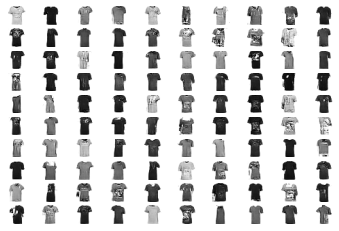

[  0   0 100   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[2]
1


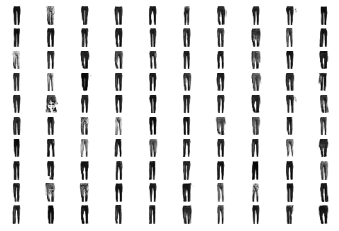

[  0   0   0 100   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[3]
2


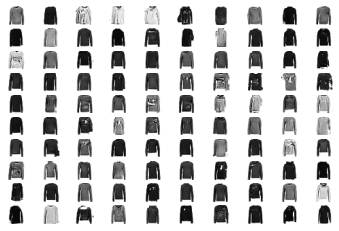

[  0   0   0   0 100   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[4]
3


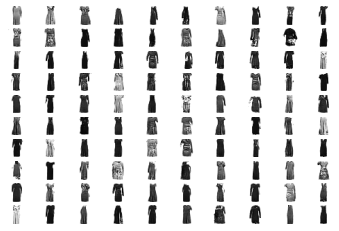

[  0   0   0   0   0 100   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[5]
4


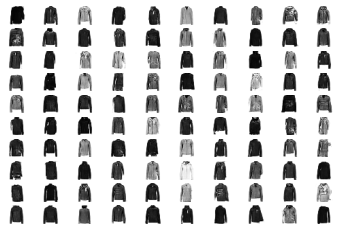

[  0   0   0   0   0   0 100   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[6]
5


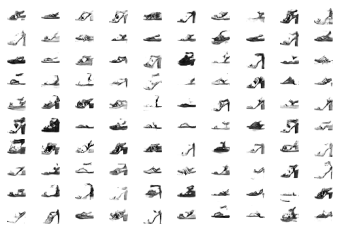

[100   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[0]
0


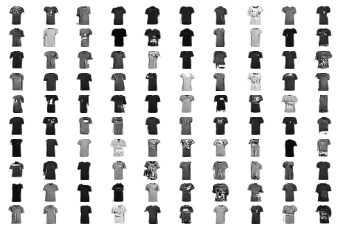

[  0   0   0   0   0   0   0   0 100   0   0   0   0   0   0   0   0   0
   0   0]
[8]
7


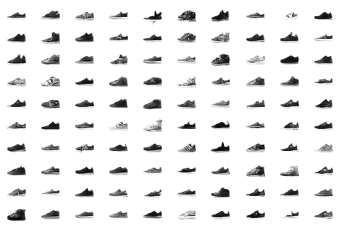

[  0   0   0   0   0   0   0   0   0 100   0   0   0   0   0   0   0   0
   0   0]
[9]
8


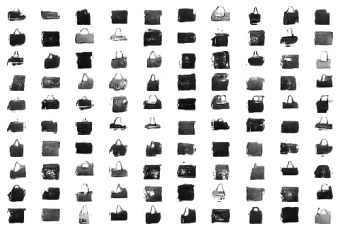

[  0   0   0   0   0   0   0   0   0   0 100   0   0   0   0   0   0   0
   0   0]
[10]
9


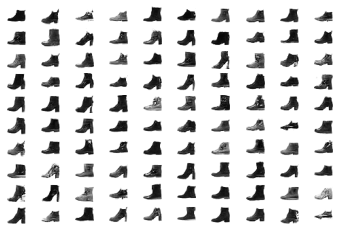

{'T-shirt/top': 1.2493277, 'Trouser': 1.0269244, 'Pullover': 1.7155468, 'Dress': 1.5093755, 'Coat': 1.4957124, 'Sandal': 1.1725008, 'Shirt': 1.2907912, 'Sneaker': 1.2396109, 'Bag': 1.6873624, 'Ankle boot': 1.1865658}


In [ ]:
d = {}
predictions_dict = {}
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for class_name in class_names:
  lb = get_class_category_value(class_name)
  reshaped_image = np.reshape(generate_images(gan_model, lb), (100, 28, 28)) # all images have shape (28, 28, 1) which is converted to (28, 28)
  predictions = probability_model.predict(reshaped_image)
  inception_score = calculate_inception_score(asarray(predictions))
  d[class_name] = inception_score
  predictions_dict[class_name] = predictions

print(d) # this can be later presented in a graph, inception score for all the categories

In [ ]:
d

{'Ankle boot': 1.1865658,
 'Bag': 1.6873624,
 'Coat': 1.4957124,
 'Dress': 1.5093755,
 'Pullover': 1.7155468,
 'Sandal': 1.1725008,
 'Shirt': 1.2907912,
 'Sneaker': 1.2396109,
 'T-shirt/top': 1.2493277,
 'Trouser': 1.0269244}

In [ ]:
p_yx = asarray([[0, 0, 0, 0,
        0, 0, 0, 0.51,
        0, 0.49]])
calculate_inception_score(p_yx)


1.0

In [ ]:
sum(predictions[0])

1.0000000062659726

In [ ]:
discriminatory_result_model.predict(reshaped_image)

KeyboardInterrupt: ignored

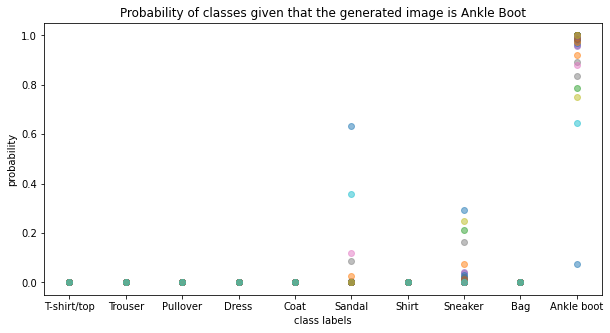

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for prediction in predictions:
  x = class_names
  y = prediction
  
  plt.scatter(x, y,alpha=0.5)


plt.title('Probability of classes given that the generated image is Ankle Boot')
plt.xlabel('class labels')
plt.ylabel('probability')
plt.savefig('ScatterPlot_07.png')

plt.show()

In [ ]:
for class_name in class_names:
  arr = predictions_dict[class_name]
  c = {}
  for l in arr:
    n = np.argmax(l)
    if n in c:
      c[n] +=1
    else:
      c[n] = 1

  print(class_name, c)


T-shirt/top {0: 94, 1: 1, 6: 4, 3: 1}
Trouser {1: 100}
Pullover {2: 66, 1: 1, 4: 16, 6: 14, 0: 2, 8: 1}
Dress {3: 88, 0: 4, 4: 3, 1: 2, 6: 2, 2: 1}
Coat {8: 1, 4: 75, 6: 20, 2: 3, 0: 1}
Sandal {5: 96, 7: 3, 8: 1}
Shirt {0: 92, 6: 4, 4: 1, 1: 1, 3: 1, 2: 1}
Sneaker {7: 94, 8: 1, 9: 2, 5: 3}
Bag {8: 84, 7: 3, 4: 1, 9: 1, 1: 1, 5: 6, 6: 3, 0: 1}
Ankle boot {9: 95, 7: 3, 5: 2}


In [ ]:
np.argmax(predictions[0])

9